# Two Object Tracking

### Summary of notebook

* <b> Simulation of the two object tracking </b>
    * A direct implementation of the clique tree.
    * Investigation of teh priors' influence.
* <b> Covariance matrices and the SVD </b>
    * Plotting the ellipse

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pylab as plt
from mpl_toolkits import mplot3d
from canonical_gaussian import CanonicalGaussian
from calc_traj import calc_traj
from range_doppler import *
from util import *

np.set_printoptions(precision=3)

## Kalman Filter

### The target

In [2]:
names, p0, v0, w0 = load_clubs('clubs.csv')

cpi = 40e-3
T = 12
t_sim = np.arange(0, T, cpi)
t, p, v = calc_traj(p0[0, :], v0[0, :], w0[0, :], t_sim)

In [3]:
sensor_locations = np.array([[-10, 28.5, 1], [-15, 30.3, 3],
                             [200, 30, 1.5], [220, -31, 2],
                             [-30, 0, 0.5], [150, 10, 0.6]])

r_d = range_doppler(sensor_locations, p, v)
p_m = multilateration(sensor_locations, r_d[:, :, 1])
v_m = determine_velocity(t, p_m, r_d[:, :, 0])

## The Kalman Filter Model

In [4]:
N = 6
M, _ = p.shape

dt = cpi
g = 9.81

sigma_r = 0.1
sigma_q = 2.5

In [5]:
A = np.identity(N)
A[0, 1] = A[2, 3] = A[4, 5] = dt 

B = np.zeros((N, N))
B[4, 4] = B[5, 5] = 1

R = np.identity(N)*sigma_r

C = np.identity(N)
Q = np.identity(N)*sigma_q

u = np.zeros((6, 1))
u[4] = -0.5*g*(dt**2)
u[5] = -g*dt

In [6]:
mu_0 = np.zeros((N, 1))
mu_0[[1, 3, 5], :] = v[0, :].reshape(3, 1)

sig_0 = np.identity(N)
g_0 = -0.5*(mu_0.T)@(mu_0) -3*np.log(2*np.pi)

In [7]:
z_t = np.empty((M, N))

z_t[:, [0, 2, 4]] = p_m
z_t[:, [1, 3, 5]] = v_m

In [8]:
R_in = np.linalg.inv(R)
P_pred = np.bmat([[R_in, -(R_in)@(A)], [-(A.T)@(R_in), (A.T)@(R_in)@(A)]])
M_pred = np.zeros((2*N, 1))
M_pred[:N, :] = (B)@(u)

h_pred = (P_pred)@(M_pred)
g_pred = -0.5*(M_pred.T)@(P_pred)@(M_pred) -0.5*np.log( np.linalg.det(2*np.pi*R))

In [9]:
Q_in = np.linalg.inv(Q)
P_meas = np.bmat([[(C.T)@(Q_in)@(C), -(C.T)@(Q_in)], [-(Q_in)@(C), Q_in]])

h_meas = np.zeros((2*N, 1))
g_meas = -0.5*np.log( np.linalg.det(2*np.pi*Q))

In [10]:
L, _ = z_t.shape 

X = np.arange(0, L)
Z = np.arange(L-1, 2*L-1)

In [11]:
C_X = [CanonicalGaussian([X[0]], [N], mu_0, sig_0, g_0)]
C_Z = [None]

for i in np.arange(1, L):
    C_X.append(CanonicalGaussian([X[i], X[i-1]], [N, N], h_pred, P_pred, g_pred))
    C_Z.append(CanonicalGaussian([X[i], Z[i]], [N, N], h_meas, P_meas, g_meas))

In [12]:
predict = [C_X[0]]
mean = np.zeros((N, L))

for i in np.arange(1, L):
    C_Z[i].introduce_evidence([Z[i]], z_t[i, :])
    marg = (predict[i-1]*C_X[i]).marginalize([X[i-1]])
    predict.append(marg*C_Z[i])

    mean[:, i] = (np.linalg.inv(predict[i]._prec)@(predict[i]._info)).reshape((N, ))

In [13]:
p_e = mean[[0, 2, 4], :]
v_e = mean[[1, 3, 5], :]

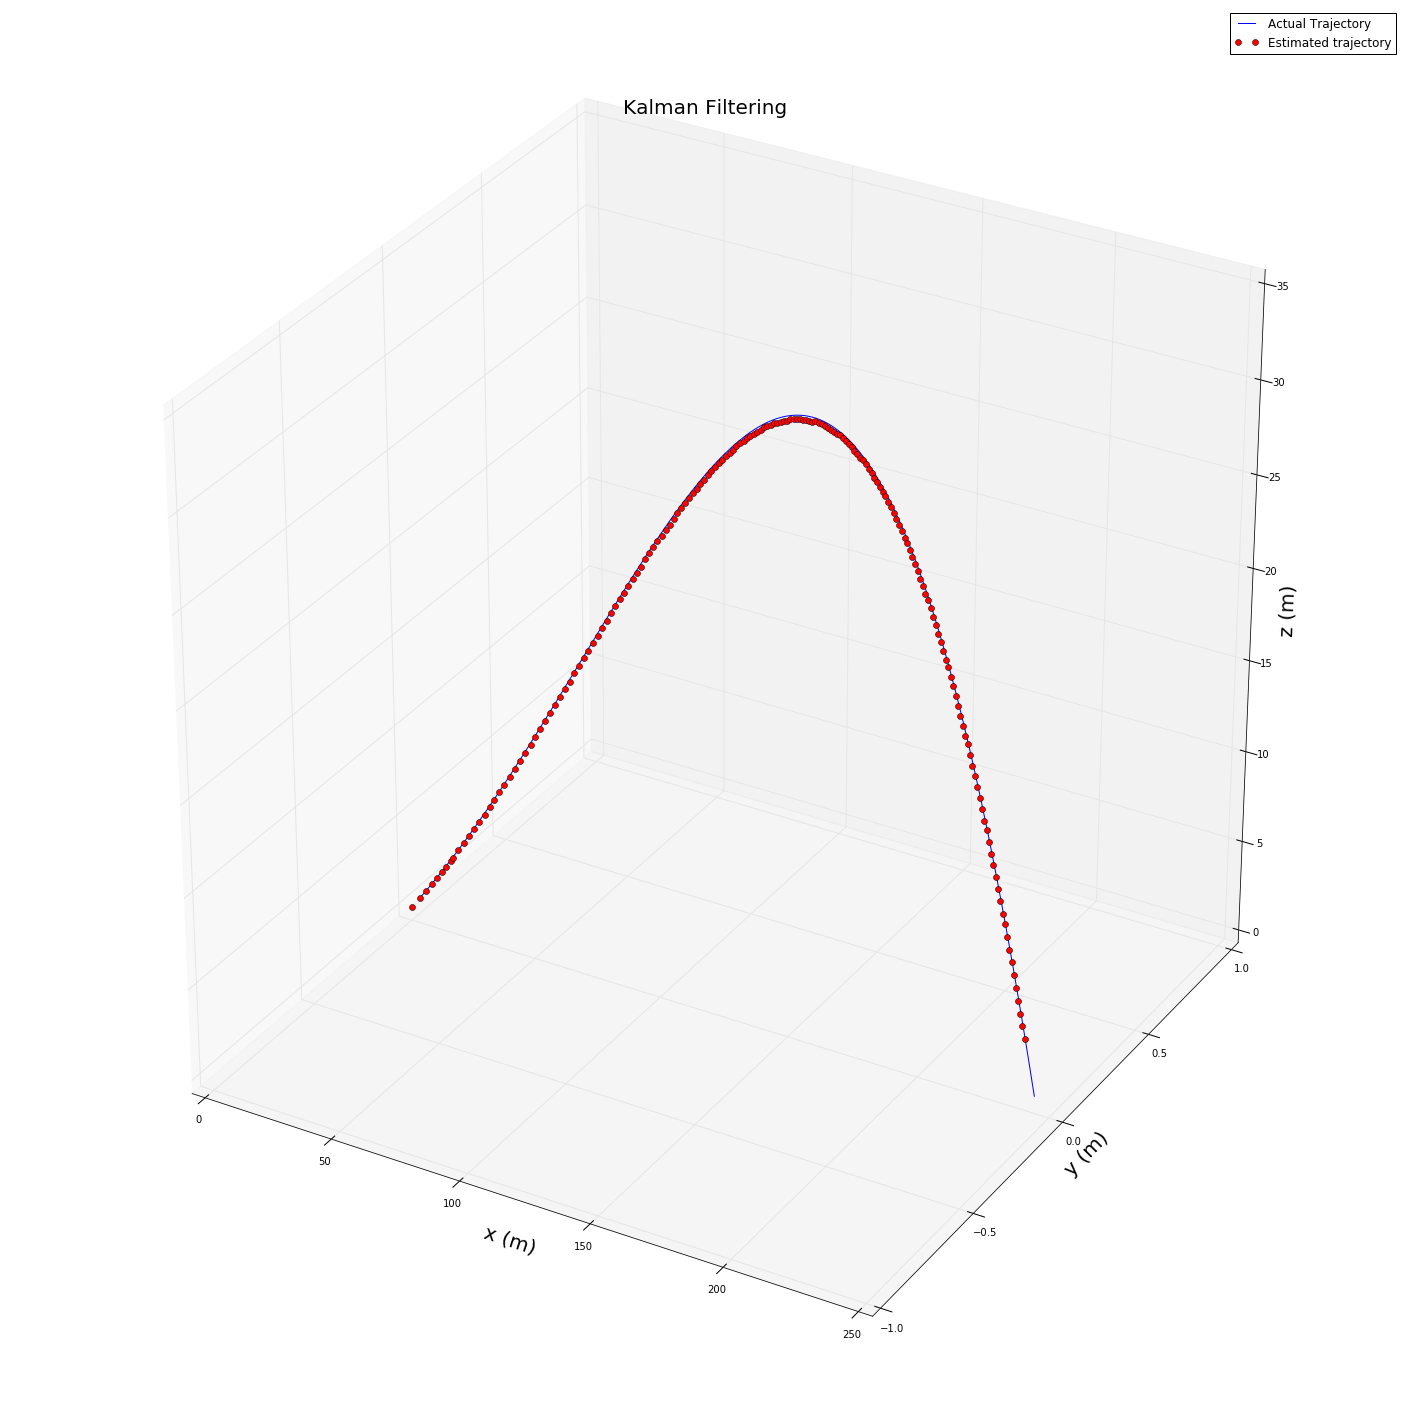

In [14]:
fig  = plt.figure(figsize=(25, 25))
ax = plt.axes(projection='3d')

ax.plot(p[:, 0], p[:, 1], p[:, 2])
ax.plot(p_e[0, :], p_e[1, :], p_e[2, :], 'or')
ax.set_xlabel('x (m)', fontsize = '20')
ax.set_ylabel('y (m)', fontsize = '20')
ax.set_zlabel('z (m)', fontsize = '20')
ax.set_title('Kalman Filtering', fontsize = '20')
ax.set_ylim([-1, 1])
ax.legend(['Actual Trajectory', 'Estimated trajectory'])
plt.show()